In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_2048_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 2048)              1697792   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 1)                 129       


Total params: 4485121 (17.11 MB)


Trainable params: 4485121 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 2:32 - loss: 0.2863 - STD: 3.6770e-05 - MAE: 0.5257

 3/64 [>.............................] - ETA: 2s - loss: 0.1265 - STD: 8.7963e-05 - MAE: 0.2977  

 5/64 [=>............................] - ETA: 3s - loss: 0.0815 - STD: 6.0228e-05 - MAE: 0.2129

 6/64 [=>............................] - ETA: 3s - loss: 0.0716 - STD: 5.0876e-05 - MAE: 0.1966

 7/64 [==>...........................] - ETA: 3s - loss: 0.0650 - STD: 4.3885e-05 - MAE: 0.1867

 8/64 [==>...........................] - ETA: 3s - loss: 0.0603 - STD: 3.8525e-05 - MAE: 0.1802

 9/64 [===>..........................] - ETA: 3s - loss: 0.0569 - STD: 3.4311e-05 - MAE: 0.1759

10/64 [===>..........................] - ETA: 3s - loss: 0.0542 - STD: 3.0927e-05 - MAE: 0.1726

11/64 [====>.........................] - ETA: 3s - loss: 0.0521 - STD: 2.8156e-05 - MAE: 0.1702

12/64 [====>.........................] - ETA: 3s - loss: 0.0504 - STD: 2.5851e-05 - MAE: 0.1682

13/64 [=====>........................] - ETA: 3s - loss: 0.0489 - STD: 2.3902e-05 - MAE: 0.1665

14/64 [=====>........................] - ETA: 3s - loss: 0.0476 - STD: 2.2234e-05 - MAE: 0.1651

15/64 [======>.......................] - ETA: 3s - loss: 0.0465 - STD: 2.0791e-05 - MAE: 0.1637

16/64 [======>.......................] - ETA: 3s - loss: 0.0455 - STD: 1.9530e-05 - MAE: 0.1624

17/64 [======>.......................] - ETA: 3s - loss: 0.0446 - STD: 1.8420e-05 - MAE: 0.1611

18/64 [=======>......................] - ETA: 3s - loss: 0.0437 - STD: 1.7436e-05 - MAE: 0.1598

19/64 [=======>......................] - ETA: 3s - loss: 0.0428 - STD: 1.6561e-05 - MAE: 0.1585

20/64 [========>.....................] - ETA: 3s - loss: 0.0420 - STD: 1.5778e-05 - MAE: 0.1572

21/64 [========>.....................] - ETA: 3s - loss: 0.0412 - STD: 1.5075e-05 - MAE: 0.1556

22/64 [=========>....................] - ETA: 3s - loss: 0.0404 - STD: 1.4442e-05 - MAE: 0.1541

23/64 [=========>....................] - ETA: 3s - loss: 0.0396 - STD: 1.3870e-05 - MAE: 0.1524

24/64 [==========>...................] - ETA: 2s - loss: 0.0388 - STD: 1.3350e-05 - MAE: 0.1505

25/64 [==========>...................] - ETA: 2s - loss: 0.0380 - STD: 1.2876e-05 - MAE: 0.1485

26/64 [===========>..................] - ETA: 2s - loss: 0.0372 - STD: 1.2438e-05 - MAE: 0.1465

27/64 [===========>..................] - ETA: 2s - loss: 0.0364 - STD: 1.2032e-05 - MAE: 0.1443

28/64 [============>.................] - ETA: 2s - loss: 0.0355 - STD: 1.1655e-05 - MAE: 0.1421

29/64 [============>.................] - ETA: 2s - loss: 0.0347 - STD: 1.1304e-05 - MAE: 0.1399

30/64 [=============>................] - ETA: 2s - loss: 0.0339 - STD: 1.0978e-05 - MAE: 0.1378

31/64 [=============>................] - ETA: 2s - loss: 0.0331 - STD: 1.0673e-05 - MAE: 0.1358

32/64 [==============>...............] - ETA: 2s - loss: 0.0324 - STD: 1.0388e-05 - MAE: 0.1341

33/64 [==============>...............] - ETA: 2s - loss: 0.0318 - STD: 1.0120e-05 - MAE: 0.1325

34/64 [==============>...............] - ETA: 2s - loss: 0.0311 - STD: 9.8690e-06 - MAE: 0.1312

35/64 [===============>..............] - ETA: 2s - loss: 0.0306 - STD: 9.6302e-06 - MAE: 0.1301

36/64 [===============>..............] - ETA: 2s - loss: 0.0301 - STD: 9.4029e-06 - MAE: 0.1292

37/64 [================>.............] - ETA: 2s - loss: 0.0296 - STD: 9.1855e-06 - MAE: 0.1283

38/64 [================>.............] - ETA: 1s - loss: 0.0292 - STD: 8.9764e-06 - MAE: 0.1274

39/64 [=================>............] - ETA: 1s - loss: 0.0287 - STD: 8.7743e-06 - MAE: 0.1266

40/64 [=================>............] - ETA: 1s - loss: 0.0283 - STD: 8.5788e-06 - MAE: 0.1257

41/64 [==================>...........] - ETA: 1s - loss: 0.0279 - STD: 8.3900e-06 - MAE: 0.1247

42/64 [==================>...........] - ETA: 1s - loss: 0.0275 - STD: 8.2076e-06 - MAE: 0.1237

43/64 [===================>..........] - ETA: 1s - loss: 0.0271 - STD: 8.0311e-06 - MAE: 0.1227

44/64 [===================>..........] - ETA: 1s - loss: 0.0267 - STD: 7.8606e-06 - MAE: 0.1217

45/64 [====================>.........] - ETA: 1s - loss: 0.0263 - STD: 7.6962e-06 - MAE: 0.1207

46/64 [====================>.........] - ETA: 1s - loss: 0.0260 - STD: 7.5379e-06 - MAE: 0.1197

47/64 [=====================>........] - ETA: 1s - loss: 0.0256 - STD: 7.3853e-06 - MAE: 0.1188

48/64 [=====================>........] - ETA: 1s - loss: 0.0253 - STD: 7.2385e-06 - MAE: 0.1179

49/64 [=====================>........] - ETA: 1s - loss: 0.0250 - STD: 7.0972e-06 - MAE: 0.1171

50/64 [======================>.......] - ETA: 1s - loss: 0.0250 - STD: 6.9611e-06 - MAE: 0.1162

52/64 [=======================>......] - ETA: 1s - loss: 0.0244 - STD: 6.7045e-06 - MAE: 0.1147

54/64 [========================>.....] - ETA: 0s - loss: 0.0239 - STD: 6.4670e-06 - MAE: 0.1133

56/64 [=========================>....] - ETA: 0s - loss: 0.0234 - STD: 6.2469e-06 - MAE: 0.1119

57/64 [=========================>....] - ETA: 0s - loss: 0.0231 - STD: 6.1429e-06 - MAE: 0.1113

58/64 [==========================>...] - ETA: 0s - loss: 0.0229 - STD: 6.0427e-06 - MAE: 0.1107

59/64 [==========================>...] - ETA: 0s - loss: 0.0227 - STD: 5.9460e-06 - MAE: 0.1102

60/64 [===========================>..] - ETA: 0s - loss: 0.0225 - STD: 5.8527e-06 - MAE: 0.1096

61/64 [===========================>..] - ETA: 0s - loss: 0.0223 - STD: 5.7626e-06 - MAE: 0.1092

62/64 [============================>.] - ETA: 0s - loss: 0.0221 - STD: 5.6755e-06 - MAE: 0.1087

63/64 [============================>.] - ETA: 0s - loss: 0.0219 - STD: 5.5910e-06 - MAE: 0.1082

64/64 [==============================] - ETA: 0s - loss: 0.0217 - STD: 5.5093e-06 - MAE: 0.1078

64/64 [==============================] - 9s 103ms/step - loss: 0.0217 - STD: 5.5093e-06 - MAE: 0.1078 - val_loss: 0.0097 - val_STD: 1.4818e-07 - val_MAE: 0.0793


Epoch 2/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0100 - STD: 3.5833e-07 - MAE: 0.0804

 2/64 [..............................] - ETA: 5s - loss: 0.0100 - STD: 3.5638e-07 - MAE: 0.0804

 3/64 [>.............................] - ETA: 5s - loss: 0.0100 - STD: 3.5327e-07 - MAE: 0.0803

 4/64 [>.............................] - ETA: 5s - loss: 0.0100 - STD: 3.5150e-07 - MAE: 0.0801

 5/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 3.4865e-07 - MAE: 0.0799

 6/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 3.4463e-07 - MAE: 0.0797

 7/64 [==>...........................] - ETA: 4s - loss: 0.0099 - STD: 3.4133e-07 - MAE: 0.0794

 8/64 [==>...........................] - ETA: 4s - loss: 0.0100 - STD: 3.3777e-07 - MAE: 0.0793

 9/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 3.3409e-07 - MAE: 0.0790

10/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 3.3056e-07 - MAE: 0.0788

11/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 3.2768e-07 - MAE: 0.0787

12/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 3.2493e-07 - MAE: 0.0785

13/64 [=====>........................] - ETA: 4s - loss: 0.0099 - STD: 3.2250e-07 - MAE: 0.0783

14/64 [=====>........................] - ETA: 4s - loss: 0.0099 - STD: 3.2016e-07 - MAE: 0.0781

15/64 [======>.......................] - ETA: 4s - loss: 0.0099 - STD: 3.1814e-07 - MAE: 0.0780

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.1684e-07 - MAE: 0.0779

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.1579e-07 - MAE: 0.0779

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 3.1511e-07 - MAE: 0.0778

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 3.1455e-07 - MAE: 0.0778

20/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 3.1431e-07 - MAE: 0.0778

21/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 3.1432e-07 - MAE: 0.0778

22/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 3.1418e-07 - MAE: 0.0778

23/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 3.1434e-07 - MAE: 0.0779

24/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 3.1487e-07 - MAE: 0.0779

25/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 3.1533e-07 - MAE: 0.0779

26/64 [===========>..................] - ETA: 3s - loss: 0.0099 - STD: 3.1578e-07 - MAE: 0.0780

27/64 [===========>..................] - ETA: 3s - loss: 0.0099 - STD: 3.1606e-07 - MAE: 0.0780

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 3.1671e-07 - MAE: 0.0780

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 3.1689e-07 - MAE: 0.0780

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 3.1697e-07 - MAE: 0.0780

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 3.1705e-07 - MAE: 0.0780

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 3.1698e-07 - MAE: 0.0780

34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 3.1707e-07 - MAE: 0.0780

35/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 3.1715e-07 - MAE: 0.0780

36/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 3.1734e-07 - MAE: 0.0780

37/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 3.1745e-07 - MAE: 0.0780

38/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 3.1754e-07 - MAE: 0.0780

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.1776e-07 - MAE: 0.0780

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.1798e-07 - MAE: 0.0780

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.1827e-07 - MAE: 0.0780

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.1862e-07 - MAE: 0.0780

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.1905e-07 - MAE: 0.0780

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.1940e-07 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.1979e-07 - MAE: 0.0780

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.2024e-07 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.2077e-07 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.2123e-07 - MAE: 0.0779

49/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.2174e-07 - MAE: 0.0779

50/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 3.2225e-07 - MAE: 0.0779

51/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 3.2282e-07 - MAE: 0.0780

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.2338e-07 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.2394e-07 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.2452e-07 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.2512e-07 - MAE: 0.0780

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.2571e-07 - MAE: 0.0780

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.2635e-07 - MAE: 0.0780

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.2705e-07 - MAE: 0.0780

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.2780e-07 - MAE: 0.0780

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.2852e-07 - MAE: 0.0780

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.2922e-07 - MAE: 0.0780

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.2998e-07 - MAE: 0.0780

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.3069e-07 - MAE: 0.0780

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 3.3144e-07 - MAE: 0.0780

64/64 [==============================] - 5s 85ms/step - loss: 0.0099 - STD: 3.3144e-07 - MAE: 0.0780 - val_loss: 0.0094 - val_STD: 2.1272e-07 - val_MAE: 0.0765


Epoch 3/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0098 - STD: 3.8694e-07 - MAE: 0.0775

 2/64 [..............................] - ETA: 5s - loss: 0.0100 - STD: 3.8689e-07 - MAE: 0.0781

 3/64 [>.............................] - ETA: 5s - loss: 0.0100 - STD: 3.8774e-07 - MAE: 0.0784

 4/64 [>.............................] - ETA: 4s - loss: 0.0100 - STD: 3.8827e-07 - MAE: 0.0783

 5/64 [=>............................] - ETA: 4s - loss: 0.0100 - STD: 3.8979e-07 - MAE: 0.0784

 6/64 [=>............................] - ETA: 4s - loss: 0.0100 - STD: 3.9108e-07 - MAE: 0.0783

 7/64 [==>...........................] - ETA: 4s - loss: 0.0100 - STD: 3.9266e-07 - MAE: 0.0784

 8/64 [==>...........................] - ETA: 4s - loss: 0.0100 - STD: 3.9453e-07 - MAE: 0.0784

 9/64 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 3.9532e-07 - MAE: 0.0783

10/64 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 3.9672e-07 - MAE: 0.0783

11/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 3.9802e-07 - MAE: 0.0782

12/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 3.9946e-07 - MAE: 0.0781

13/64 [=====>........................] - ETA: 4s - loss: 0.0099 - STD: 4.0069e-07 - MAE: 0.0781

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 4.0233e-07 - MAE: 0.0781

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 4.0348e-07 - MAE: 0.0782

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 4.0480e-07 - MAE: 0.0781

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 4.0633e-07 - MAE: 0.0781

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 4.0767e-07 - MAE: 0.0781

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 4.0921e-07 - MAE: 0.0781

20/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 4.1069e-07 - MAE: 0.0780

21/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 4.1226e-07 - MAE: 0.0781

22/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 4.1385e-07 - MAE: 0.0781

23/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 4.1570e-07 - MAE: 0.0780

24/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 4.1762e-07 - MAE: 0.0780

25/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 4.1914e-07 - MAE: 0.0780

26/64 [===========>..................] - ETA: 3s - loss: 0.0099 - STD: 4.2106e-07 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.2277e-07 - MAE: 0.0780

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.2458e-07 - MAE: 0.0780

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.2609e-07 - MAE: 0.0780

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.2796e-07 - MAE: 0.0779

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.2992e-07 - MAE: 0.0780

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 4.3183e-07 - MAE: 0.0780

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 4.3339e-07 - MAE: 0.0779

34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 4.3525e-07 - MAE: 0.0779

35/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 4.3708e-07 - MAE: 0.0779

36/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 4.3902e-07 - MAE: 0.0779

37/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 4.4087e-07 - MAE: 0.0779

38/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 4.4295e-07 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.4488e-07 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.4690e-07 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 4.4876e-07 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 4.5081e-07 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 4.5277e-07 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 4.5481e-07 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 4.5696e-07 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 4.5899e-07 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 4.6087e-07 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 4.6291e-07 - MAE: 0.0779

49/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 4.6484e-07 - MAE: 0.0779

50/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 4.6677e-07 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 4.7100e-07 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 4.7303e-07 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 4.7521e-07 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 4.7764e-07 - MAE: 0.0780

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 4.8004e-07 - MAE: 0.0780

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 4.8229e-07 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.8463e-07 - MAE: 0.0780

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.8685e-07 - MAE: 0.0780

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.8930e-07 - MAE: 0.0780

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.9161e-07 - MAE: 0.0780

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.9385e-07 - MAE: 0.0780

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.9609e-07 - MAE: 0.0780

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 4.9834e-07 - MAE: 0.0780

64/64 [==============================] - 5s 83ms/step - loss: 0.0099 - STD: 4.9834e-07 - MAE: 0.0780 - val_loss: 0.0094 - val_STD: 4.3690e-07 - val_MAE: 0.0763


Epoch 4/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0098 - STD: 6.4044e-07 - MAE: 0.0770

 2/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 6.4973e-07 - MAE: 0.0772

 3/64 [>.............................] - ETA: 5s - loss: 0.0099 - STD: 6.5426e-07 - MAE: 0.0777

 4/64 [>.............................] - ETA: 5s - loss: 0.0099 - STD: 6.5626e-07 - MAE: 0.0777

 5/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 6.5942e-07 - MAE: 0.0777

 6/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 6.6359e-07 - MAE: 0.0779

 7/64 [==>...........................] - ETA: 4s - loss: 0.0100 - STD: 6.6662e-07 - MAE: 0.0780

 8/64 [==>...........................] - ETA: 4s - loss: 0.0100 - STD: 6.7018e-07 - MAE: 0.0780

 9/64 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 6.7377e-07 - MAE: 0.0781

10/64 [===>..........................] - ETA: 4s - loss: 0.0100 - STD: 6.7705e-07 - MAE: 0.0781

11/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 6.8042e-07 - MAE: 0.0780

12/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 6.8335e-07 - MAE: 0.0781

13/64 [=====>........................] - ETA: 4s - loss: 0.0099 - STD: 6.8630e-07 - MAE: 0.0780

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 6.8948e-07 - MAE: 0.0779

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 6.9223e-07 - MAE: 0.0778

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 6.9456e-07 - MAE: 0.0779

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 6.9716e-07 - MAE: 0.0778

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 6.9984e-07 - MAE: 0.0778

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 7.0248e-07 - MAE: 0.0778

20/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 7.0526e-07 - MAE: 0.0779

21/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 7.0823e-07 - MAE: 0.0778

22/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 7.1136e-07 - MAE: 0.0779

23/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 7.1466e-07 - MAE: 0.0779

24/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 7.1790e-07 - MAE: 0.0779

25/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 7.2103e-07 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 7.2816e-07 - MAE: 0.0778

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 7.3185e-07 - MAE: 0.0779

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 7.3514e-07 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 7.3819e-07 - MAE: 0.0778

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 7.4158e-07 - MAE: 0.0778

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 7.4493e-07 - MAE: 0.0779

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 7.4807e-07 - MAE: 0.0778

34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 7.5144e-07 - MAE: 0.0778

35/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 7.5478e-07 - MAE: 0.0778

36/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 7.5789e-07 - MAE: 0.0778

37/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 7.6106e-07 - MAE: 0.0778

38/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 7.6451e-07 - MAE: 0.0778

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.6774e-07 - MAE: 0.0778

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.7114e-07 - MAE: 0.0778

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.7495e-07 - MAE: 0.0778

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.7865e-07 - MAE: 0.0778

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.8242e-07 - MAE: 0.0778

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.8614e-07 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 7.8977e-07 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 7.9341e-07 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 7.9698e-07 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 8.0071e-07 - MAE: 0.0779

49/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 8.0424e-07 - MAE: 0.0779

50/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 8.0801e-07 - MAE: 0.0779

51/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 8.1155e-07 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 8.1518e-07 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 8.1880e-07 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 8.2224e-07 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 8.2577e-07 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 8.2933e-07 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 8.3305e-07 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 8.3681e-07 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 8.4049e-07 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 8.4433e-07 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 8.4832e-07 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 8.5195e-07 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 8.5587e-07 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 8.5977e-07 - MAE: 0.0779

64/64 [==============================] - 5s 83ms/step - loss: 0.0099 - STD: 8.5977e-07 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 8.0154e-07 - val_MAE: 0.0766


Epoch 5/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0096 - STD: 1.1154e-06 - MAE: 0.0768

 2/64 [..............................] - ETA: 5s - loss: 0.0099 - STD: 1.1199e-06 - MAE: 0.0779

 3/64 [>.............................] - ETA: 5s - loss: 0.0099 - STD: 1.1249e-06 - MAE: 0.0781

 4/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 1.1288e-06 - MAE: 0.0782

 5/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 1.1355e-06 - MAE: 0.0781

 6/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 1.1390e-06 - MAE: 0.0779

 7/64 [==>...........................] - ETA: 4s - loss: 0.0099 - STD: 1.1427e-06 - MAE: 0.0780

 8/64 [==>...........................] - ETA: 4s - loss: 0.0099 - STD: 1.1482e-06 - MAE: 0.0780

 9/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 1.1524e-06 - MAE: 0.0778

10/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 1.1563e-06 - MAE: 0.0778

11/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 1.1603e-06 - MAE: 0.0778

12/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 1.1643e-06 - MAE: 0.0778

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.1749e-06 - MAE: 0.0776

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.1805e-06 - MAE: 0.0777

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.1861e-06 - MAE: 0.0777

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.1914e-06 - MAE: 0.0778

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 1.1966e-06 - MAE: 0.0778

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 1.2012e-06 - MAE: 0.0778

20/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 1.2070e-06 - MAE: 0.0779

21/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 1.2121e-06 - MAE: 0.0778

22/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 1.2175e-06 - MAE: 0.0779

23/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 1.2226e-06 - MAE: 0.0779

24/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 1.2277e-06 - MAE: 0.0779

25/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 1.2327e-06 - MAE: 0.0779

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.2380e-06 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.2427e-06 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.2477e-06 - MAE: 0.0779

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.2528e-06 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.2580e-06 - MAE: 0.0779

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.2632e-06 - MAE: 0.0779

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.2680e-06 - MAE: 0.0779

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.2735e-06 - MAE: 0.0780

34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.2786e-06 - MAE: 0.0779

35/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 1.2843e-06 - MAE: 0.0779

36/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 1.2899e-06 - MAE: 0.0779

37/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 1.2953e-06 - MAE: 0.0779

38/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 1.3006e-06 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.3063e-06 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.3121e-06 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.3177e-06 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.3230e-06 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.3287e-06 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.3342e-06 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.3395e-06 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.3454e-06 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.3511e-06 - MAE: 0.0778

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.3568e-06 - MAE: 0.0779

49/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.3622e-06 - MAE: 0.0778

50/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 1.3677e-06 - MAE: 0.0778

51/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 1.3738e-06 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.3794e-06 - MAE: 0.0778

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.3851e-06 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.3907e-06 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.3967e-06 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.4028e-06 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.4091e-06 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.4155e-06 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.4220e-06 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.4283e-06 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.4342e-06 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.4404e-06 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.4465e-06 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.4527e-06 - MAE: 0.0779

64/64 [==============================] - 5s 84ms/step - loss: 0.0099 - STD: 1.4527e-06 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 1.3500e-06 - val_MAE: 0.0763


Epoch 6/10000


 1/64 [..............................] - ETA: 9s - loss: 0.0097 - STD: 1.8489e-06 - MAE: 0.0771

 2/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 1.8669e-06 - MAE: 0.0770

 3/64 [>.............................] - ETA: 5s - loss: 0.0099 - STD: 1.8708e-06 - MAE: 0.0774

 4/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 1.8781e-06 - MAE: 0.0774

 5/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 1.8823e-06 - MAE: 0.0774

 6/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 1.8872e-06 - MAE: 0.0775

 7/64 [==>...........................] - ETA: 4s - loss: 0.0099 - STD: 1.8985e-06 - MAE: 0.0775

 9/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 1.9168e-06 - MAE: 0.0777

10/64 [===>..........................] - ETA: 4s - loss: 0.0099 - STD: 1.9265e-06 - MAE: 0.0777

11/64 [====>.........................] - ETA: 4s - loss: 0.0099 - STD: 1.9390e-06 - MAE: 0.0778

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.9482e-06 - MAE: 0.0779

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.9558e-06 - MAE: 0.0780

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.9647e-06 - MAE: 0.0779

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.9730e-06 - MAE: 0.0779

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.9818e-06 - MAE: 0.0779

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.9895e-06 - MAE: 0.0779

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 1.9961e-06 - MAE: 0.0779

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 2.0025e-06 - MAE: 0.0778

20/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 2.0101e-06 - MAE: 0.0778

21/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 2.0179e-06 - MAE: 0.0779

22/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 2.0253e-06 - MAE: 0.0779

23/64 [=========>....................] - ETA: 3s - loss: 0.0099 - STD: 2.0344e-06 - MAE: 0.0778

24/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 2.0442e-06 - MAE: 0.0779

25/64 [==========>...................] - ETA: 3s - loss: 0.0099 - STD: 2.0536e-06 - MAE: 0.0779

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.0628e-06 - MAE: 0.0779

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.0717e-06 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.0812e-06 - MAE: 0.0779

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.0916e-06 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.1012e-06 - MAE: 0.0780

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.1097e-06 - MAE: 0.0780

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 2.1188e-06 - MAE: 0.0780

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 2.1277e-06 - MAE: 0.0780

34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 2.1369e-06 - MAE: 0.0780

35/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 2.1459e-06 - MAE: 0.0780

36/64 [===============>..............] - ETA: 2s - loss: 0.0099 - STD: 2.1551e-06 - MAE: 0.0780

37/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 2.1642e-06 - MAE: 0.0780

38/64 [================>.............] - ETA: 2s - loss: 0.0099 - STD: 2.1729e-06 - MAE: 0.0780

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.1825e-06 - MAE: 0.0780

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.1917e-06 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.2015e-06 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.2113e-06 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.2212e-06 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.2312e-06 - MAE: 0.0780

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.2410e-06 - MAE: 0.0780

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.2511e-06 - MAE: 0.0780

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 2.2613e-06 - MAE: 0.0780

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 2.2710e-06 - MAE: 0.0780

49/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 2.2805e-06 - MAE: 0.0779

50/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 2.2905e-06 - MAE: 0.0779

51/64 [======================>.......] - ETA: 1s - loss: 0.0099 - STD: 2.3009e-06 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.3112e-06 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.3209e-06 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.3311e-06 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.3422e-06 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.3524e-06 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.3632e-06 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.3738e-06 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.3846e-06 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.3956e-06 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.4071e-06 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.4185e-06 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.4296e-06 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 2.4406e-06 - MAE: 0.0779

64/64 [==============================] - 5s 84ms/step - loss: 0.0099 - STD: 2.4406e-06 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 2.3152e-06 - val_MAE: 0.0764


Epoch 7/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0099 - STD: 3.1786e-06 - MAE: 0.0780

 2/64 [..............................] - ETA: 3s - loss: 0.0099 - STD: 3.2023e-06 - MAE: 0.0779

 3/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 3.2089e-06 - MAE: 0.0778

 4/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 3.2150e-06 - MAE: 0.0778

 5/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 3.2260e-06 - MAE: 0.0777

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 3.2357e-06 - MAE: 0.0775

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.2516e-06 - MAE: 0.0775

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.2664e-06 - MAE: 0.0775

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.2756e-06 - MAE: 0.0775

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 3.2938e-06 - MAE: 0.0776

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 3.3063e-06 - MAE: 0.0775

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 3.3201e-06 - MAE: 0.0774

13/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 3.3360e-06 - MAE: 0.0775

14/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 3.3518e-06 - MAE: 0.0775

15/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 3.3666e-06 - MAE: 0.0776

16/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 3.3806e-06 - MAE: 0.0776

17/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 3.3960e-06 - MAE: 0.0776

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.4119e-06 - MAE: 0.0777

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.4265e-06 - MAE: 0.0777

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.4447e-06 - MAE: 0.0777

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.4630e-06 - MAE: 0.0777

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.4794e-06 - MAE: 0.0777

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.4977e-06 - MAE: 0.0778

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 3.5154e-06 - MAE: 0.0778

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 3.5330e-06 - MAE: 0.0778

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 3.5488e-06 - MAE: 0.0778

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 3.5655e-06 - MAE: 0.0778

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 3.5813e-06 - MAE: 0.0778

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 3.5972e-06 - MAE: 0.0778

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 3.6139e-06 - MAE: 0.0777

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 3.6310e-06 - MAE: 0.0777

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 3.6470e-06 - MAE: 0.0777

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 3.6647e-06 - MAE: 0.0777

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 3.6828e-06 - MAE: 0.0777

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 3.7005e-06 - MAE: 0.0777

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 3.7190e-06 - MAE: 0.0777

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 3.7372e-06 - MAE: 0.0777

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.7722e-06 - MAE: 0.0777

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.7907e-06 - MAE: 0.0778

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.8113e-06 - MAE: 0.0778

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.8314e-06 - MAE: 0.0778

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.8505e-06 - MAE: 0.0778

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.8701e-06 - MAE: 0.0778

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.8904e-06 - MAE: 0.0778

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.9097e-06 - MAE: 0.0778

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.9293e-06 - MAE: 0.0779

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.9487e-06 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.9694e-06 - MAE: 0.0779

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.9895e-06 - MAE: 0.0779

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 4.0096e-06 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 4.0302e-06 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 4.0505e-06 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 4.0720e-06 - MAE: 0.0778

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 4.0926e-06 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 4.1133e-06 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 4.1348e-06 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.1556e-06 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.1771e-06 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.1991e-06 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.2207e-06 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.2428e-06 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 4.2655e-06 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 4.2891e-06 - MAE: 0.0779

64/64 [==============================] - 4s 63ms/step - loss: 0.0099 - STD: 4.2891e-06 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 4.2426e-06 - val_MAE: 0.0766


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0099 - STD: 5.8326e-06 - MAE: 0.0782

 2/64 [..............................] - ETA: 4s - loss: 0.0099 - STD: 5.8306e-06 - MAE: 0.0781

 3/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 5.8555e-06 - MAE: 0.0780

 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 5.8848e-06 - MAE: 0.0782

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 5.8855e-06 - MAE: 0.0781

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 5.9167e-06 - MAE: 0.0781

 7/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 5.9589e-06 - MAE: 0.0782

 8/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 5.9801e-06 - MAE: 0.0783

 9/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 6.0143e-06 - MAE: 0.0782

10/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 6.0333e-06 - MAE: 0.0781

11/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 6.0738e-06 - MAE: 0.0781

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 6.1057e-06 - MAE: 0.0781

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 6.1396e-06 - MAE: 0.0781

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 6.1758e-06 - MAE: 0.0781

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 6.2030e-06 - MAE: 0.0781

16/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 6.2314e-06 - MAE: 0.0781

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 6.2630e-06 - MAE: 0.0781

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 6.2960e-06 - MAE: 0.0781

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 6.3292e-06 - MAE: 0.0781

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 6.3631e-06 - MAE: 0.0781

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 6.3930e-06 - MAE: 0.0780

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 6.4297e-06 - MAE: 0.0780

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 6.4631e-06 - MAE: 0.0780

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 6.5011e-06 - MAE: 0.0780

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 6.5396e-06 - MAE: 0.0780

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.5756e-06 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.6101e-06 - MAE: 0.0780

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 6.6456e-06 - MAE: 0.0779

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 6.6816e-06 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 6.7190e-06 - MAE: 0.0779

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 6.7538e-06 - MAE: 0.0779

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 6.7896e-06 - MAE: 0.0779

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 6.8263e-06 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 6.8651e-06 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 6.9064e-06 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 6.9484e-06 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 6.9901e-06 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 7.0311e-06 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.0726e-06 - MAE: 0.0780

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.1113e-06 - MAE: 0.0780

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.1518e-06 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.1929e-06 - MAE: 0.0780

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.2335e-06 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.2740e-06 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 7.3154e-06 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 7.3572e-06 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 7.4007e-06 - MAE: 0.0779

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 7.4451e-06 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 7.4929e-06 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 7.5379e-06 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 7.6290e-06 - MAE: 0.0778

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 7.6753e-06 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 7.7235e-06 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 7.7710e-06 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 7.8182e-06 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 7.8669e-06 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 7.9141e-06 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 7.9618e-06 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 8.0140e-06 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 8.0675e-06 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 8.1194e-06 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 8.1743e-06 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 8.2286e-06 - MAE: 0.0779

64/64 [==============================] - 4s 64ms/step - loss: 0.0099 - STD: 8.2286e-06 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 8.5672e-06 - val_MAE: 0.0766


Epoch 9/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0098 - STD: 1.1687e-05 - MAE: 0.0777

 2/64 [..............................] - ETA: 3s - loss: 0.0099 - STD: 1.1734e-05 - MAE: 0.0779

 3/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 1.1812e-05 - MAE: 0.0777

 4/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 1.1885e-05 - MAE: 0.0775

 5/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 1.1954e-05 - MAE: 0.0776

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.2002e-05 - MAE: 0.0777

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.2072e-05 - MAE: 0.0776

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.2147e-05 - MAE: 0.0777

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.2231e-05 - MAE: 0.0778

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.2321e-05 - MAE: 0.0777

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.2423e-05 - MAE: 0.0778

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.2523e-05 - MAE: 0.0778

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.2621e-05 - MAE: 0.0779

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.2720e-05 - MAE: 0.0779

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.2810e-05 - MAE: 0.0779

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.2893e-05 - MAE: 0.0780

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.2970e-05 - MAE: 0.0780

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.3059e-05 - MAE: 0.0779

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.3142e-05 - MAE: 0.0779

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.3231e-05 - MAE: 0.0779

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.3321e-05 - MAE: 0.0779

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.3405e-05 - MAE: 0.0779

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.3489e-05 - MAE: 0.0778

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.3584e-05 - MAE: 0.0778

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.3690e-05 - MAE: 0.0778

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.3784e-05 - MAE: 0.0778

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.3885e-05 - MAE: 0.0778

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.3985e-05 - MAE: 0.0778

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.4087e-05 - MAE: 0.0778

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.4189e-05 - MAE: 0.0778

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.4292e-05 - MAE: 0.0778

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.4403e-05 - MAE: 0.0778

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.4512e-05 - MAE: 0.0778

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.4620e-05 - MAE: 0.0778

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.4733e-05 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.4851e-05 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.4965e-05 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.5082e-05 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.5201e-05 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.5320e-05 - MAE: 0.0778

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.5443e-05 - MAE: 0.0778

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.5570e-05 - MAE: 0.0778

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.5693e-05 - MAE: 0.0778

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.5819e-05 - MAE: 0.0778

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.5947e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.6071e-05 - MAE: 0.0778

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.6203e-05 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.6475e-05 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.6619e-05 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.6769e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.6919e-05 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.7077e-05 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.7232e-05 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.7387e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.7541e-05 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.7693e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.7849e-05 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.8003e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.8166e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.8329e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.8496e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.8669e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.8850e-05 - MAE: 0.0779

64/64 [==============================] - 4s 65ms/step - loss: 0.0099 - STD: 1.8850e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 2.2410e-05 - val_MAE: 0.0766


Epoch 10/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0102 - STD: 3.0513e-05 - MAE: 0.0790

 2/64 [..............................] - ETA: 3s - loss: 0.0101 - STD: 3.0918e-05 - MAE: 0.0786

 3/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 3.1426e-05 - MAE: 0.0782

 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 3.1759e-05 - MAE: 0.0782

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 3.2028e-05 - MAE: 0.0780

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 3.2242e-05 - MAE: 0.0780

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.2540e-05 - MAE: 0.0778

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 3.2783e-05 - MAE: 0.0777

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 3.3053e-05 - MAE: 0.0778

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 3.3328e-05 - MAE: 0.0777

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 3.3688e-05 - MAE: 0.0778

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 3.4010e-05 - MAE: 0.0778

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 3.4426e-05 - MAE: 0.0778

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 3.4794e-05 - MAE: 0.0779

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.5221e-05 - MAE: 0.0779

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 3.5637e-05 - MAE: 0.0779

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 3.6052e-05 - MAE: 0.0779

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.6440e-05 - MAE: 0.0779

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 3.6831e-05 - MAE: 0.0779

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.7181e-05 - MAE: 0.0779

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.7580e-05 - MAE: 0.0779

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.8011e-05 - MAE: 0.0780

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.8451e-05 - MAE: 0.0780

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 3.8892e-05 - MAE: 0.0780

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 3.9360e-05 - MAE: 0.0780

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 3.9824e-05 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.0298e-05 - MAE: 0.0780

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.0776e-05 - MAE: 0.0780

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.1258e-05 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.1769e-05 - MAE: 0.0779

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.2266e-05 - MAE: 0.0779

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 4.2751e-05 - MAE: 0.0779

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 4.3287e-05 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 4.3806e-05 - MAE: 0.0778

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 4.4372e-05 - MAE: 0.0778

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 4.4954e-05 - MAE: 0.0778

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 4.5556e-05 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 4.6165e-05 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.6782e-05 - MAE: 0.0778

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.7415e-05 - MAE: 0.0778

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 4.8073e-05 - MAE: 0.0778

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 4.8722e-05 - MAE: 0.0778

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 4.9397e-05 - MAE: 0.0778

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.0090e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.1558e-05 - MAE: 0.0778

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.2312e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 5.3097e-05 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 5.3860e-05 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.4668e-05 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.5490e-05 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.6349e-05 - MAE: 0.0778

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.7225e-05 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.8121e-05 - MAE: 0.0778

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.9055e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 6.0004e-05 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 6.0965e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.1975e-05 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.3024e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 6.4082e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 6.5187e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 6.6309e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 6.7472e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 6.8664e-05 - MAE: 0.0779

64/64 [==============================] - 4s 65ms/step - loss: 0.0099 - STD: 6.8664e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 1.0682e-04 - val_MAE: 0.0761


Epoch 11/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0099 - STD: 1.4654e-04 - MAE: 0.0776

 2/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 1.5016e-04 - MAE: 0.0777

 3/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 1.5212e-04 - MAE: 0.0776

 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 1.5458e-04 - MAE: 0.0777

 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.5738e-04 - MAE: 0.0775

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.6007e-04 - MAE: 0.0775

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.6301e-04 - MAE: 0.0777

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.6613e-04 - MAE: 0.0778

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.6930e-04 - MAE: 0.0778

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.7253e-04 - MAE: 0.0779

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.7575e-04 - MAE: 0.0781

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.7918e-04 - MAE: 0.0780

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.8297e-04 - MAE: 0.0780

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.8672e-04 - MAE: 0.0780

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.9040e-04 - MAE: 0.0780

16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.9430e-04 - MAE: 0.0780

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.9830e-04 - MAE: 0.0780

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 2.0226e-04 - MAE: 0.0780

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 2.0644e-04 - MAE: 0.0779

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.1092e-04 - MAE: 0.0779

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.1550e-04 - MAE: 0.0780

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.2027e-04 - MAE: 0.0780

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.2495e-04 - MAE: 0.0780

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.3006e-04 - MAE: 0.0780

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.3543e-04 - MAE: 0.0780

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.4105e-04 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.4687e-04 - MAE: 0.0780

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.5270e-04 - MAE: 0.0780

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.5887e-04 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.6521e-04 - MAE: 0.0779

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.7906e-04 - MAE: 0.0780

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.8619e-04 - MAE: 0.0780

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.9353e-04 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 3.0135e-04 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 3.0954e-04 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 3.1817e-04 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 3.2726e-04 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.3665e-04 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.4648e-04 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.5675e-04 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.6752e-04 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.7859e-04 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.9005e-04 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 4.0178e-04 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 4.1424e-04 - MAE: 0.0778

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 4.2724e-04 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 4.4081e-04 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 4.5512e-04 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 4.7022e-04 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 4.8593e-04 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.0212e-04 - MAE: 0.0778

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.1935e-04 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.3740e-04 - MAE: 0.0778

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.5634e-04 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.7640e-04 - MAE: 0.0778

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.9724e-04 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.1875e-04 - MAE: 0.0778

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.4115e-04 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 6.6501e-04 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 6.8979e-04 - MAE: 0.0777

62/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 7.1595e-04 - MAE: 0.0777

63/64 [============================>.] - ETA: 0s - loss: 0.0098 - STD: 7.4303e-04 - MAE: 0.0777

64/64 [==============================] - ETA: 0s - loss: 0.0098 - STD: 7.7210e-04 - MAE: 0.0777

64/64 [==============================] - 4s 64ms/step - loss: 0.0098 - STD: 7.7210e-04 - MAE: 0.0777 - val_loss: 0.0092 - val_STD: 0.0019 - val_MAE: 0.0758


Epoch 12/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0098 - STD: 0.0028 - MAE: 0.0776

 2/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 0.0028 - MAE: 0.0776

 3/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0775

 4/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0030 - MAE: 0.0774

 5/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0031 - MAE: 0.0772

 6/64 [=>............................] - ETA: 3s - loss: 0.0096 - STD: 0.0032 - MAE: 0.0771

 7/64 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 0.0033 - MAE: 0.0771

 8/64 [==>...........................] - ETA: 3s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0769

 9/64 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.0035 - MAE: 0.0768

10/64 [===>..........................] - ETA: 3s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0768

11/64 [====>.........................] - ETA: 3s - loss: 0.0096 - STD: 0.0037 - MAE: 0.0768

12/64 [====>.........................] - ETA: 3s - loss: 0.0096 - STD: 0.0038 - MAE: 0.0767

13/64 [=====>........................] - ETA: 3s - loss: 0.0096 - STD: 0.0040 - MAE: 0.0767

14/64 [=====>........................] - ETA: 3s - loss: 0.0096 - STD: 0.0041 - MAE: 0.0768

15/64 [======>.......................] - ETA: 3s - loss: 0.0096 - STD: 0.0042 - MAE: 0.0768

16/64 [======>.......................] - ETA: 2s - loss: 0.0095 - STD: 0.0044 - MAE: 0.0767

17/64 [======>.......................] - ETA: 2s - loss: 0.0095 - STD: 0.0046 - MAE: 0.0767

18/64 [=======>......................] - ETA: 2s - loss: 0.0095 - STD: 0.0047 - MAE: 0.0767

19/64 [=======>......................] - ETA: 2s - loss: 0.0095 - STD: 0.0049 - MAE: 0.0766

20/64 [========>.....................] - ETA: 2s - loss: 0.0095 - STD: 0.0050 - MAE: 0.0766

21/64 [========>.....................] - ETA: 2s - loss: 0.0095 - STD: 0.0052 - MAE: 0.0766

22/64 [=========>....................] - ETA: 2s - loss: 0.0095 - STD: 0.0054 - MAE: 0.0765

23/64 [=========>....................] - ETA: 2s - loss: 0.0095 - STD: 0.0055 - MAE: 0.0764

24/64 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.0057 - MAE: 0.0764

25/64 [==========>...................] - ETA: 2s - loss: 0.0095 - STD: 0.0059 - MAE: 0.0764

26/64 [===========>..................] - ETA: 2s - loss: 0.0095 - STD: 0.0062 - MAE: 0.0764

27/64 [===========>..................] - ETA: 2s - loss: 0.0094 - STD: 0.0064 - MAE: 0.0763

28/64 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0066 - MAE: 0.0763

29/64 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0069 - MAE: 0.0762

30/64 [=============>................] - ETA: 2s - loss: 0.0094 - STD: 0.0071 - MAE: 0.0762

31/64 [=============>................] - ETA: 2s - loss: 0.0094 - STD: 0.0074 - MAE: 0.0761

32/64 [==============>...............] - ETA: 1s - loss: 0.0094 - STD: 0.0076 - MAE: 0.0760

33/64 [==============>...............] - ETA: 1s - loss: 0.0093 - STD: 0.0079 - MAE: 0.0759

34/64 [==============>...............] - ETA: 1s - loss: 0.0093 - STD: 0.0081 - MAE: 0.0758

35/64 [===============>..............] - ETA: 1s - loss: 0.0093 - STD: 0.0084 - MAE: 0.0758

36/64 [===============>..............] - ETA: 1s - loss: 0.0093 - STD: 0.0086 - MAE: 0.0757

37/64 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 0.0089 - MAE: 0.0757

38/64 [================>.............] - ETA: 1s - loss: 0.0093 - STD: 0.0092 - MAE: 0.0756

39/64 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.0095 - MAE: 0.0755

40/64 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 0.0098 - MAE: 0.0755

41/64 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.0101 - MAE: 0.0754

42/64 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 0.0105 - MAE: 0.0754

44/64 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 0.0111 - MAE: 0.0753

45/64 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 0.0114 - MAE: 0.0752

46/64 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 0.0117 - MAE: 0.0752

47/64 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 0.0120 - MAE: 0.0751

48/64 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0123 - MAE: 0.0750

49/64 [=====================>........] - ETA: 0s - loss: 0.0091 - STD: 0.0127 - MAE: 0.0749

50/64 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0130 - MAE: 0.0749

51/64 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0133 - MAE: 0.0748

52/64 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0136 - MAE: 0.0747

53/64 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0139 - MAE: 0.0746

54/64 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0143 - MAE: 0.0746

55/64 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0146 - MAE: 0.0745

56/64 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0148 - MAE: 0.0744

57/64 [=========================>....] - ETA: 0s - loss: 0.0090 - STD: 0.0151 - MAE: 0.0743

58/64 [==========================>...] - ETA: 0s - loss: 0.0090 - STD: 0.0154 - MAE: 0.0743

59/64 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.0157 - MAE: 0.0742

60/64 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0160 - MAE: 0.0741

61/64 [===========================>..] - ETA: 0s - loss: 0.0089 - STD: 0.0163 - MAE: 0.0741

62/64 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0165 - MAE: 0.0740

63/64 [============================>.] - ETA: 0s - loss: 0.0089 - STD: 0.0168 - MAE: 0.0739

64/64 [==============================] - ETA: 0s - loss: 0.0089 - STD: 0.0171 - MAE: 0.0738

64/64 [==============================] - 4s 65ms/step - loss: 0.0089 - STD: 0.0171 - MAE: 0.0738 - val_loss: 0.0073 - val_STD: 0.0251 - val_MAE: 0.0669


Epoch 13/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0077 - STD: 0.0360 - MAE: 0.0685

 2/64 [..............................] - ETA: 4s - loss: 0.0076 - STD: 0.0362 - MAE: 0.0680

 3/64 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.0361 - MAE: 0.0682

 4/64 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.0359 - MAE: 0.0681

 5/64 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.0358 - MAE: 0.0682

 6/64 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.0359 - MAE: 0.0679

 7/64 [==>...........................] - ETA: 3s - loss: 0.0077 - STD: 0.0358 - MAE: 0.0685

 8/64 [==>...........................] - ETA: 3s - loss: 0.0078 - STD: 0.0360 - MAE: 0.0682

 9/64 [===>..........................] - ETA: 3s - loss: 0.0078 - STD: 0.0363 - MAE: 0.0685

10/64 [===>..........................] - ETA: 3s - loss: 0.0078 - STD: 0.0366 - MAE: 0.0684

11/64 [====>.........................] - ETA: 3s - loss: 0.0078 - STD: 0.0368 - MAE: 0.0682

12/64 [====>.........................] - ETA: 3s - loss: 0.0078 - STD: 0.0369 - MAE: 0.0686

13/64 [=====>........................] - ETA: 3s - loss: 0.0078 - STD: 0.0371 - MAE: 0.0684

14/64 [=====>........................] - ETA: 3s - loss: 0.0078 - STD: 0.0370 - MAE: 0.0683

15/64 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0372 - MAE: 0.0685

16/64 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0374 - MAE: 0.0685

17/64 [======>.......................] - ETA: 2s - loss: 0.0078 - STD: 0.0375 - MAE: 0.0682

18/64 [=======>......................] - ETA: 2s - loss: 0.0078 - STD: 0.0377 - MAE: 0.0681

19/64 [=======>......................] - ETA: 2s - loss: 0.0078 - STD: 0.0379 - MAE: 0.0682

20/64 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.0381 - MAE: 0.0681

21/64 [========>.....................] - ETA: 2s - loss: 0.0077 - STD: 0.0382 - MAE: 0.0679

22/64 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.0384 - MAE: 0.0679

23/64 [=========>....................] - ETA: 2s - loss: 0.0077 - STD: 0.0386 - MAE: 0.0679

24/64 [==========>...................] - ETA: 2s - loss: 0.0077 - STD: 0.0387 - MAE: 0.0677

25/64 [==========>...................] - ETA: 2s - loss: 0.0076 - STD: 0.0388 - MAE: 0.0675

26/64 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.0390 - MAE: 0.0675

27/64 [===========>..................] - ETA: 2s - loss: 0.0076 - STD: 0.0392 - MAE: 0.0674

28/64 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.0392 - MAE: 0.0672

29/64 [============>.................] - ETA: 2s - loss: 0.0076 - STD: 0.0395 - MAE: 0.0672

30/64 [=============>................] - ETA: 2s - loss: 0.0075 - STD: 0.0397 - MAE: 0.0671

31/64 [=============>................] - ETA: 1s - loss: 0.0075 - STD: 0.0399 - MAE: 0.0669

32/64 [==============>...............] - ETA: 1s - loss: 0.0075 - STD: 0.0402 - MAE: 0.0670

33/64 [==============>...............] - ETA: 1s - loss: 0.0075 - STD: 0.0402 - MAE: 0.0669

34/64 [==============>...............] - ETA: 1s - loss: 0.0075 - STD: 0.0404 - MAE: 0.0668

35/64 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.0407 - MAE: 0.0668

36/64 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.0406 - MAE: 0.0667

37/64 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0409 - MAE: 0.0667

38/64 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0410 - MAE: 0.0665

39/64 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.0411 - MAE: 0.0664

40/64 [=================>............] - ETA: 1s - loss: 0.0074 - STD: 0.0414 - MAE: 0.0663

41/64 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0416 - MAE: 0.0662

42/64 [==================>...........] - ETA: 1s - loss: 0.0074 - STD: 0.0418 - MAE: 0.0660

43/64 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0421 - MAE: 0.0660

44/64 [===================>..........] - ETA: 1s - loss: 0.0073 - STD: 0.0423 - MAE: 0.0658

45/64 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.0425 - MAE: 0.0657

46/64 [====================>.........] - ETA: 1s - loss: 0.0073 - STD: 0.0428 - MAE: 0.0657

47/64 [=====================>........] - ETA: 1s - loss: 0.0073 - STD: 0.0429 - MAE: 0.0655

48/64 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0430 - MAE: 0.0654

49/64 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0433 - MAE: 0.0654

50/64 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0433 - MAE: 0.0653

51/64 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0436 - MAE: 0.0653

52/64 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0437 - MAE: 0.0652

53/64 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0439 - MAE: 0.0650

54/64 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0441 - MAE: 0.0650

55/64 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0443 - MAE: 0.0649

56/64 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0445 - MAE: 0.0648

58/64 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0449 - MAE: 0.0646

59/64 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0450 - MAE: 0.0645

60/64 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0453 - MAE: 0.0645

61/64 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0453 - MAE: 0.0645

62/64 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0454 - MAE: 0.0644

63/64 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0456 - MAE: 0.0643

64/64 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0456 - MAE: 0.0643

64/64 [==============================] - 4s 64ms/step - loss: 0.0071 - STD: 0.0456 - MAE: 0.0643 - val_loss: 0.0057 - val_STD: 0.0481 - val_MAE: 0.0615


Epoch 14/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0065 - STD: 0.0582 - MAE: 0.0642

 2/64 [..............................] - ETA: 4s - loss: 0.0062 - STD: 0.0552 - MAE: 0.0609

 3/64 [>.............................] - ETA: 3s - loss: 0.0062 - STD: 0.0538 - MAE: 0.0598

 4/64 [>.............................] - ETA: 3s - loss: 0.0063 - STD: 0.0556 - MAE: 0.0608

 5/64 [=>............................] - ETA: 3s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0599

 6/64 [=>............................] - ETA: 3s - loss: 0.0061 - STD: 0.0553 - MAE: 0.0595

 7/64 [==>...........................] - ETA: 3s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0593

 8/64 [==>...........................] - ETA: 3s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0590

 9/64 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0562 - MAE: 0.0589

10/64 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0587

11/64 [====>.........................] - ETA: 3s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0585

12/64 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0585

13/64 [=====>........................] - ETA: 3s - loss: 0.0059 - STD: 0.0567 - MAE: 0.0584

15/64 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0584

16/64 [======>.......................] - ETA: 2s - loss: 0.0060 - STD: 0.0573 - MAE: 0.0585

17/64 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0583

18/64 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0573 - MAE: 0.0583

19/64 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0582

20/64 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0581

21/64 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0580

22/64 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0578

23/64 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0577

24/64 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0576

25/64 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0576

26/64 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0574

27/64 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0575

28/64 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0583 - MAE: 0.0575

29/64 [============>.................] - ETA: 2s - loss: 0.0059 - STD: 0.0586 - MAE: 0.0579

30/64 [=============>................] - ETA: 2s - loss: 0.0059 - STD: 0.0579 - MAE: 0.0580

31/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0580

32/64 [==============>...............] - ETA: 1s - loss: 0.0060 - STD: 0.0576 - MAE: 0.0587

33/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0569 - MAE: 0.0588

34/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0563 - MAE: 0.0589

35/64 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0590

36/64 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0560 - MAE: 0.0594

37/64 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0558 - MAE: 0.0593

38/64 [================>.............] - ETA: 1s - loss: 0.0062 - STD: 0.0555 - MAE: 0.0594

39/64 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0554 - MAE: 0.0593

40/64 [=================>............] - ETA: 1s - loss: 0.0062 - STD: 0.0556 - MAE: 0.0596

41/64 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0557 - MAE: 0.0596

42/64 [==================>...........] - ETA: 1s - loss: 0.0062 - STD: 0.0555 - MAE: 0.0596

43/64 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0553 - MAE: 0.0596

44/64 [===================>..........] - ETA: 1s - loss: 0.0062 - STD: 0.0554 - MAE: 0.0596

45/64 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0554 - MAE: 0.0597

46/64 [====================>.........] - ETA: 1s - loss: 0.0062 - STD: 0.0553 - MAE: 0.0596

47/64 [=====================>........] - ETA: 1s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0596

48/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0595

49/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0552 - MAE: 0.0596

50/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0552 - MAE: 0.0596

51/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0595

52/64 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0594

53/64 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0553 - MAE: 0.0594

54/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0554 - MAE: 0.0594

55/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0555 - MAE: 0.0593

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0556 - MAE: 0.0592

57/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0558 - MAE: 0.0592

58/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0592

59/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0559 - MAE: 0.0591

60/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0561 - MAE: 0.0590

61/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0590

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0562 - MAE: 0.0589

63/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0563 - MAE: 0.0588

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0564 - MAE: 0.0588

64/64 [==============================] - 4s 65ms/step - loss: 0.0061 - STD: 0.0564 - MAE: 0.0588 - val_loss: 0.0049 - val_STD: 0.0538 - val_MAE: 0.0545


Epoch 15/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0551

 2/64 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0548

 3/64 [>.............................] - ETA: 3s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0549

 4/64 [>.............................] - ETA: 3s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0551

 5/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0628 - MAE: 0.0549

 6/64 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0548

 7/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0550

 8/64 [==>...........................] - ETA: 3s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0548

 9/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0547

10/64 [===>..........................] - ETA: 3s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0549

11/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0547

12/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0546

13/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0547

14/64 [=====>........................] - ETA: 3s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0545

15/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0545

16/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0545

17/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0545

18/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0642 - MAE: 0.0544

19/64 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0644 - MAE: 0.0544

20/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0543

21/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0542

22/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0542

23/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0542

24/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0541

25/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0541

26/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0541

27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0648 - MAE: 0.0541

28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0540

29/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0540

30/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0540

31/64 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0539

32/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0539

33/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0539

34/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0652 - MAE: 0.0538

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0652 - MAE: 0.0538

36/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0538

37/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0537

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0654 - MAE: 0.0538

39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0538

40/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0540

41/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0542

42/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0650 - MAE: 0.0542

43/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0544

45/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0545

46/64 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0548

47/64 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0548

48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0548

49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0548

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0548

51/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0548

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0548

53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0640 - MAE: 0.0549

54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0549

55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0548

56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0549

57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0637 - MAE: 0.0549

58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0549

59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0635 - MAE: 0.0548

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0549

61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0548

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0636 - MAE: 0.0548

63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0549

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0638 - MAE: 0.0548

64/64 [==============================] - 4s 63ms/step - loss: 0.0053 - STD: 0.0638 - MAE: 0.0548 - val_loss: 0.0049 - val_STD: 0.0543 - val_MAE: 0.0521


Epoch 16/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0052 - STD: 0.0615 - MAE: 0.0520

 2/64 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0539

 3/64 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0538

 4/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0641 - MAE: 0.0533

 5/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0640 - MAE: 0.0530

 6/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0649 - MAE: 0.0537

 7/64 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0646 - MAE: 0.0535

 9/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0648 - MAE: 0.0536

10/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0535

11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0647 - MAE: 0.0534

12/64 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0533

13/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0535

14/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0533

15/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0531

16/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0533

17/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0533

18/64 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0655 - MAE: 0.0531

19/64 [=======>......................] - ETA: 2s - loss: 0.0050 - STD: 0.0658 - MAE: 0.0531

20/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0531

21/64 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0530

22/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0661 - MAE: 0.0529

23/64 [=========>....................] - ETA: 2s - loss: 0.0050 - STD: 0.0664 - MAE: 0.0529

24/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0664 - MAE: 0.0528

25/64 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0528

26/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0527

27/64 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0527

28/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0669 - MAE: 0.0527

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0526

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0525

31/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0525

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0672 - MAE: 0.0525

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0671 - MAE: 0.0524

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0524

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0524

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0673 - MAE: 0.0523

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0674 - MAE: 0.0523

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0523

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0522

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0522

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0522

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0521

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0521

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0521

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0520

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0520

47/64 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0680 - MAE: 0.0520

48/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0519

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0519

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0519

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0519

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0519

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0519

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0520

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0519

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0519

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0519

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0519

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0519

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0518

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0518

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0518

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0518

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0519

64/64 [==============================] - 4s 64ms/step - loss: 0.0048 - STD: 0.0684 - MAE: 0.0519 - val_loss: 0.0043 - val_STD: 0.0584 - val_MAE: 0.0492


Epoch 17/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0633 - MAE: 0.0508

 2/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0636 - MAE: 0.0503

 3/64 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0663 - MAE: 0.0519

 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0516

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0665 - MAE: 0.0516

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0673 - MAE: 0.0512

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0517

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0678 - MAE: 0.0516

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0681 - MAE: 0.0516

11/64 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0683 - MAE: 0.0515

12/64 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0679 - MAE: 0.0514

13/64 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0682 - MAE: 0.0515

14/64 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0684 - MAE: 0.0515

15/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0513

16/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0688 - MAE: 0.0513

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0690 - MAE: 0.0512

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0511

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0511

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0511

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0511

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0510

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0510

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0509

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0509

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0509

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0509

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0510

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0509

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0509

31/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0508

32/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0508

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0508

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0508

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0508

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0507

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0507

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0507

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0507

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0508

41/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0508

42/64 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0509

43/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0509

44/64 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0508

45/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0509

46/64 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0509

47/64 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0509

48/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0509

49/64 [=====================>........] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0509

50/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0509

51/64 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0509

52/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0699 - MAE: 0.0509

53/64 [=======================>......] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0509

54/64 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0700 - MAE: 0.0508

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0508

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0508

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0508

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0508

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0507

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0507

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0507

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0506

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0506

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0506

64/64 [==============================] - 4s 64ms/step - loss: 0.0046 - STD: 0.0704 - MAE: 0.0506 - val_loss: 0.0042 - val_STD: 0.0688 - val_MAE: 0.0503


Epoch 18/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0043 - STD: 0.0767 - MAE: 0.0503

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0494

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0494

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0494

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0492

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0492

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0495

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0498

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0498

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0499

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0498

15/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0500

16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0499

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0499

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0499

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0712 - MAE: 0.0498

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0498

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0498

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0498

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0498

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0497

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0497

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0497

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0497

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0497

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0497

31/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0496

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0497

33/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0496

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0495

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0495

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0495

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

43/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0496

44/64 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

45/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

46/64 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

47/64 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0501

48/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0501

49/64 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0501

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0503

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0503

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0503

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0505

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0505

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0507

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0507

60/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0508

61/64 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0508

62/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0507

63/64 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0508

64/64 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0508

64/64 [==============================] - 4s 64ms/step - loss: 0.0047 - STD: 0.0704 - MAE: 0.0508 - val_loss: 0.0042 - val_STD: 0.0593 - val_MAE: 0.0482


Epoch 19/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0046 - STD: 0.0670 - MAE: 0.0488

 2/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0719 - MAE: 0.0517

 3/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0508

 4/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0692 - MAE: 0.0503

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0507

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0505

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0696 - MAE: 0.0503

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0503

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0503

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0501

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0499

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0499

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0497

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0496

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0496

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0496

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0495

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0495

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0715 - MAE: 0.0495

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0714 - MAE: 0.0494

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0494

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0493

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0493

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0492

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0492

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0491

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0491

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0491

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0491

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0491

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0491

32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0490

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0491

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0490

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0723 - MAE: 0.0490

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0490

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0490

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0490

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0490

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0490

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0490

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0490

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0489

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0489

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0489

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0489

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0489

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0489

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0489

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0488

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0488

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0489

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0488

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0489

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0488

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0488

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0488

64/64 [==============================] - 4s 64ms/step - loss: 0.0043 - STD: 0.0730 - MAE: 0.0488 - val_loss: 0.0045 - val_STD: 0.0736 - val_MAE: 0.0525


Epoch 20/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0049 - STD: 0.0818 - MAE: 0.0536

 2/64 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0721 - MAE: 0.0530

 3/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0741 - MAE: 0.0525

 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0736 - MAE: 0.0516

 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0718 - MAE: 0.0510

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0723 - MAE: 0.0510

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0506

 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502

 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0503

10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0501

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498

14/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0497

15/64 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0497

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0495

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0494

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0496

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0496

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0495

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0495

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0496

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0493

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0492

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0490

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0490

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0490

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0489

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0489

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0489

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0488

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0489

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0489

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0732 - MAE: 0.0490

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0490

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0490

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0491

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491

64/64 [==============================] - 4s 64ms/step - loss: 0.0044 - STD: 0.0729 - MAE: 0.0491 - val_loss: 0.0039 - val_STD: 0.0630 - val_MAE: 0.0467


Epoch 21/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0473

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0475

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0488

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0487

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0488

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0490

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0489

 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0488

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0489

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0489

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0723 - MAE: 0.0487

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0486

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487

15/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0484

16/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0484

17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0484

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0483

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0483

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0483

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0483

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0483

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0482

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0482

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0482

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0482

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0482

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0482

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0481

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0481

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0481

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0480

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0480

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0480

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0481

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0481

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0481

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0481

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0480

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0480

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0480

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0480

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0480

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0479

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479

64/64 [==============================] - 4s 64ms/step - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479 - val_loss: 0.0038 - val_STD: 0.0683 - val_MAE: 0.0459


Epoch 22/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0473

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0471

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0768 - MAE: 0.0474

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0474

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0473

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0471

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0471

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0471

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0470

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0471

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0471

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

64/64 [==============================] - 4s 64ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471 - val_loss: 0.0038 - val_STD: 0.0668 - val_MAE: 0.0457


Epoch 23/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0465

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0471

 4/64 [>.............................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0476

 5/64 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0474

 6/64 [=>............................] - ETA: 2s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0477

 7/64 [==>...........................] - ETA: 2s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0476

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0475

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0474

10/64 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0473

11/64 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0474

12/64 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0473

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

30/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

64/64 [==============================] - 4s 63ms/step - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470 - val_loss: 0.0038 - val_STD: 0.0706 - val_MAE: 0.0479


Epoch 24/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0776 - MAE: 0.0486

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0472

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0469

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0470

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0468

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0751 - MAE: 0.0468

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0466

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0466

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0466

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0465

32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0470

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0470

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0469

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469

64/64 [==============================] - 5s 70ms/step - loss: 0.0040 - STD: 0.0755 - MAE: 0.0469 - val_loss: 0.0037 - val_STD: 0.0704 - val_MAE: 0.0452


Epoch 25/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0456

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0457

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0458

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0458

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0773 - MAE: 0.0463

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0464

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0771 - MAE: 0.0465

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0770 - MAE: 0.0464

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0464

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0769 - MAE: 0.0465

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0465

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0465

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

64/64 [==============================] - 4s 63ms/step - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464 - val_loss: 0.0038 - val_STD: 0.0717 - val_MAE: 0.0473


Epoch 26/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0472

 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0753 - MAE: 0.0461

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0776 - MAE: 0.0470

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0473

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0769 - MAE: 0.0471

 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0476

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0471

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0470

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0470

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0752 - MAE: 0.0470

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0469

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0470

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0469

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0468

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0468

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0467

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0466

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0466

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0466

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0466

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0464

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

64/64 [==============================] - 4s 64ms/step - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463 - val_loss: 0.0037 - val_STD: 0.0701 - val_MAE: 0.0463


Epoch 27/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0468

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0459

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0457

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0459

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0457

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0456

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0455

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0455

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0456

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0456

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0457

15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0456

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

64/64 [==============================] - 4s 63ms/step - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457 - val_loss: 0.0039 - val_STD: 0.0657 - val_MAE: 0.0456


Epoch 28/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0728 - MAE: 0.0467

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0788 - MAE: 0.0491

 3/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0743 - MAE: 0.0493

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0755 - MAE: 0.0492

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0753 - MAE: 0.0485

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0481

 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0484

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0483

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0480

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0479

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0474

15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0471

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0754 - MAE: 0.0469

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0465

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0464

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0465

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0465

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462

64/64 [==============================] - 4s 64ms/step - loss: 0.0039 - STD: 0.0764 - MAE: 0.0462 - val_loss: 0.0035 - val_STD: 0.0710 - val_MAE: 0.0444


Epoch 29/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0447

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0449

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0450

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0456

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0456

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0457

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0457

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0456

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

64/64 [==============================] - 4s 64ms/step - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456 - val_loss: 0.0036 - val_STD: 0.0728 - val_MAE: 0.0449


Epoch 30/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0806 - MAE: 0.0449

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0454

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

64/64 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454 - val_loss: 0.0041 - val_STD: 0.0767 - val_MAE: 0.0494


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0840 - MAE: 0.0485

 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0777 - MAE: 0.0471

 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0782 - MAE: 0.0469

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0463

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0464

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0459

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0458

16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

64/64 [==============================] - 4s 64ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455 - val_loss: 0.0035 - val_STD: 0.0698 - val_MAE: 0.0442


Epoch 32/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0451

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0448

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0788 - MAE: 0.0455

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0449

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0449

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0449

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

64/64 [==============================] - 4s 63ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451 - val_loss: 0.0035 - val_STD: 0.0701 - val_MAE: 0.0440


Epoch 33/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0443

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0770 - MAE: 0.0445

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0445

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0445

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0450

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

64/64 [==============================] - 4s 65ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450 - val_loss: 0.0035 - val_STD: 0.0686 - val_MAE: 0.0435


Epoch 34/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0037 - STD: 0.0758 - MAE: 0.0440

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

64/64 [==============================] - 4s 64ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446 - val_loss: 0.0035 - val_STD: 0.0703 - val_MAE: 0.0439


Epoch 35/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0449

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

 5/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

 6/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0447

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

64/64 [==============================] - 5s 71ms/step - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452 - val_loss: 0.0035 - val_STD: 0.0707 - val_MAE: 0.0442


Epoch 36/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0441

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0741 - MAE: 0.0445

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0453

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0450

 6/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

 7/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0452

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0449

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

49/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

64/64 [==============================] - 5s 73ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0732 - val_MAE: 0.0453


Epoch 37/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0038 - STD: 0.0813 - MAE: 0.0461

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0450

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0448

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0448

 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446

 6/64 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0444

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0443

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

20/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

34/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

49/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

64/64 [==============================] - 5s 72ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446 - val_loss: 0.0041 - val_STD: 0.0632 - val_MAE: 0.0459


Epoch 38/10000


 1/64 [..............................] - ETA: 7s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0455

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0450

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0450

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0449

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0452

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0449

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0447

 8/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0450

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0449

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0447

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0444

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0444

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

20/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0443

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0442

34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

35/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

64/64 [==============================] - 5s 74ms/step - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441 - val_loss: 0.0036 - val_STD: 0.0673 - val_MAE: 0.0436


Epoch 39/10000


 1/64 [..............................] - ETA: 8s - loss: 0.0039 - STD: 0.0751 - MAE: 0.0446

 2/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0449

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0441

 5/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445

 6/64 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0449

 8/64 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0449

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0450

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0449

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

19/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

20/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

21/64 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0443

22/64 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

34/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

35/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

36/64 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

49/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

64/64 [==============================] - 5s 74ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440 - val_loss: 0.0047 - val_STD: 0.0598 - val_MAE: 0.0492


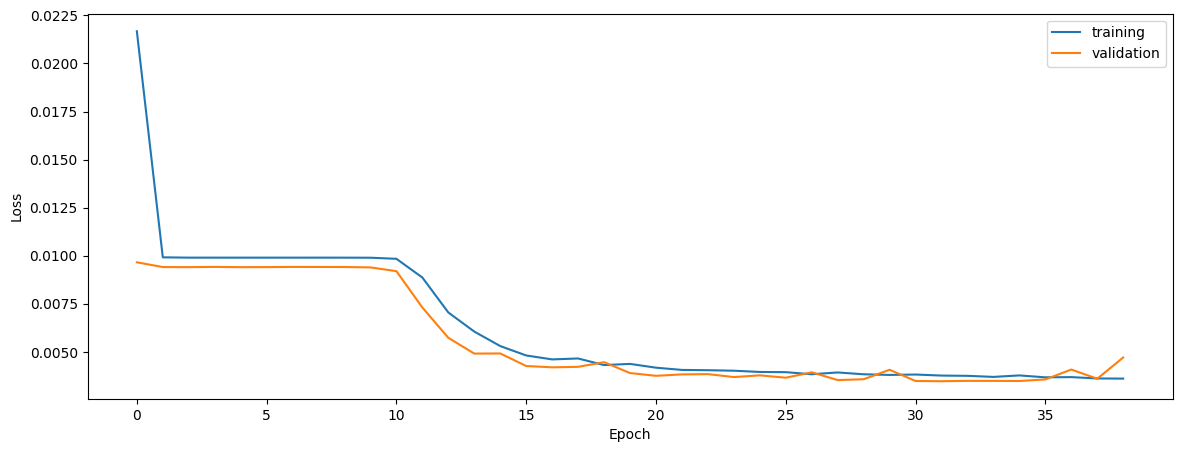

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7946090353791666
0.793986714344955
0.793121131830194


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7946090353791666
0.793986714344955
0.793121131830194


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7980934817408699
0.7932537360127909
0.7984142164053655


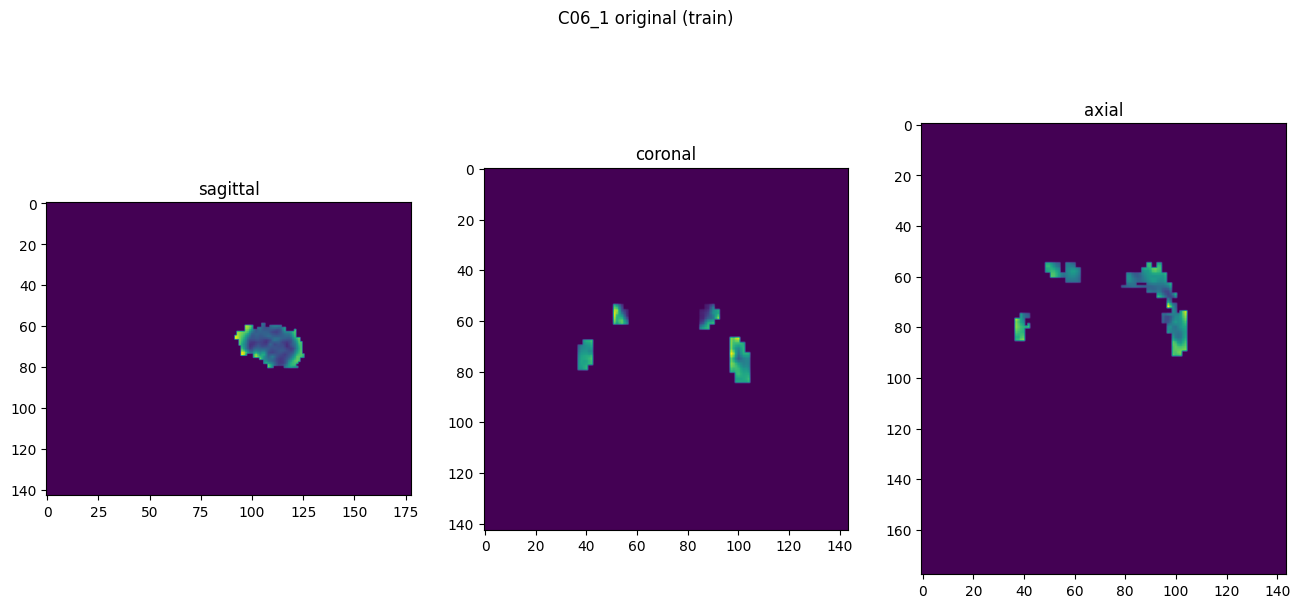

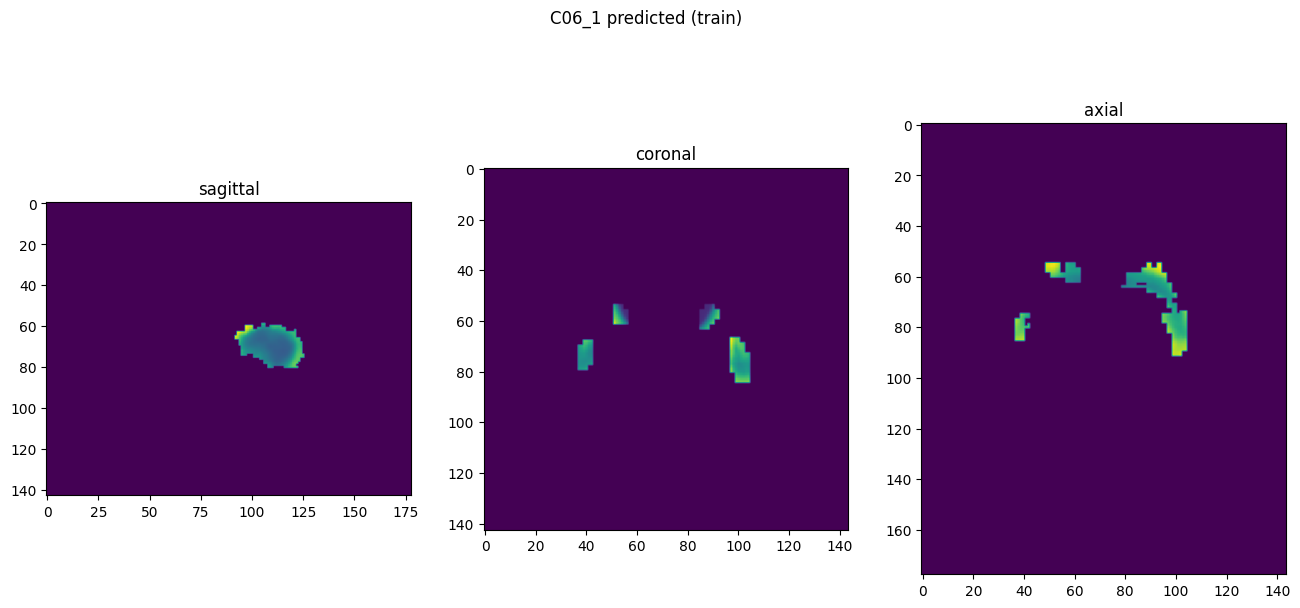

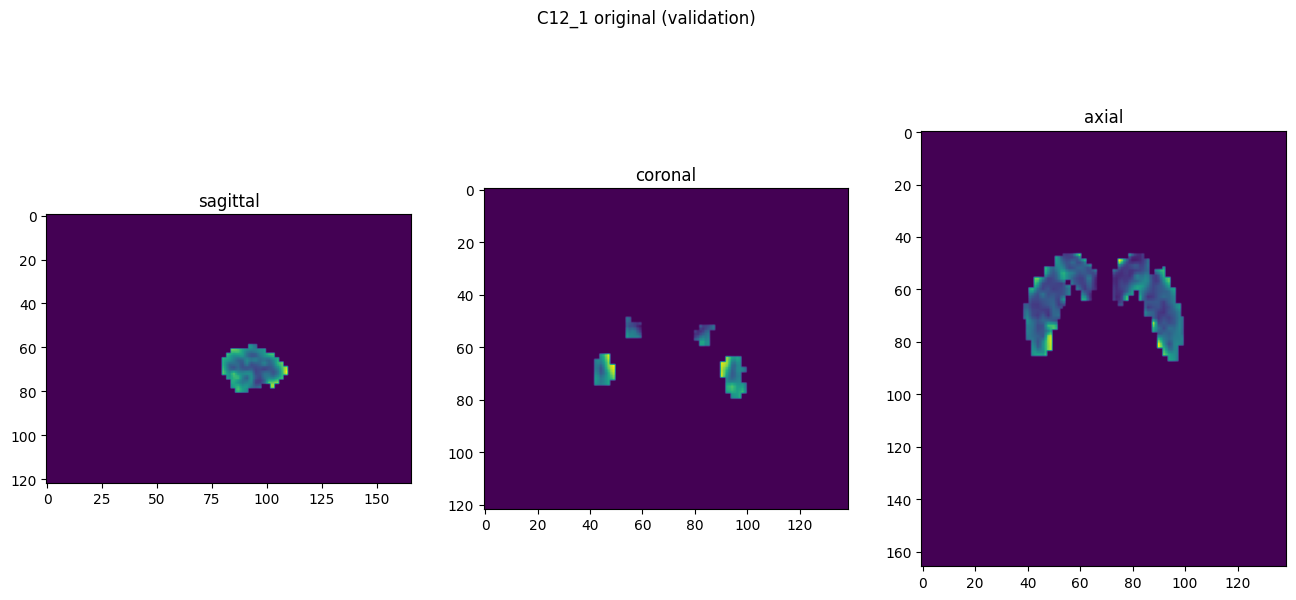

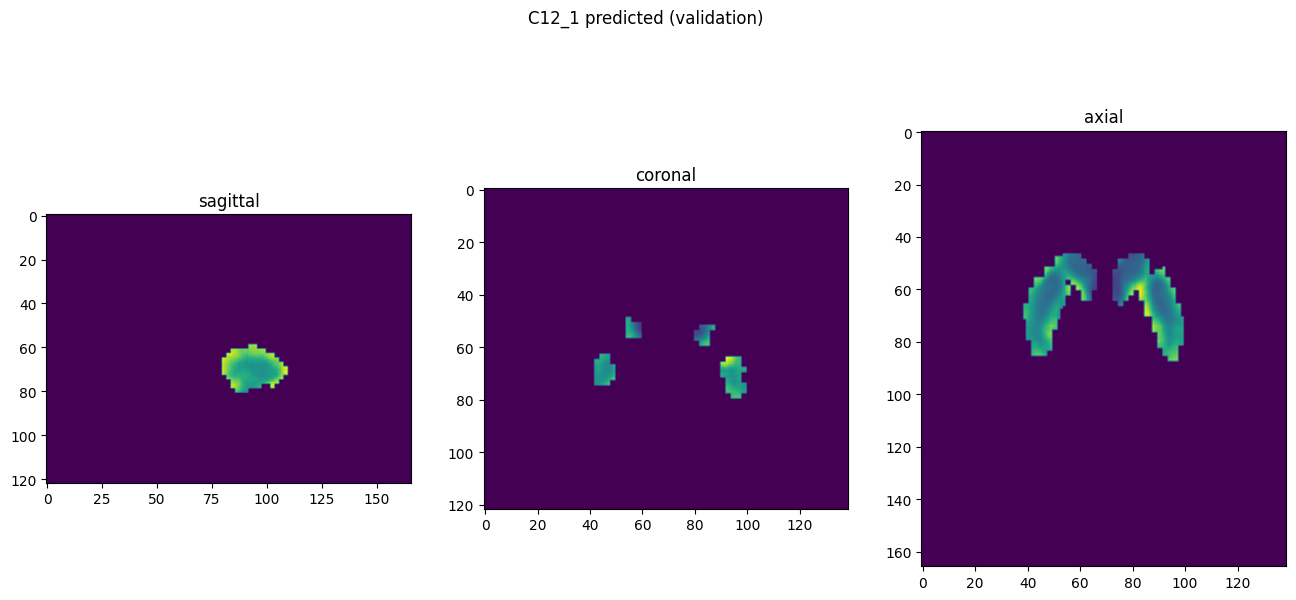

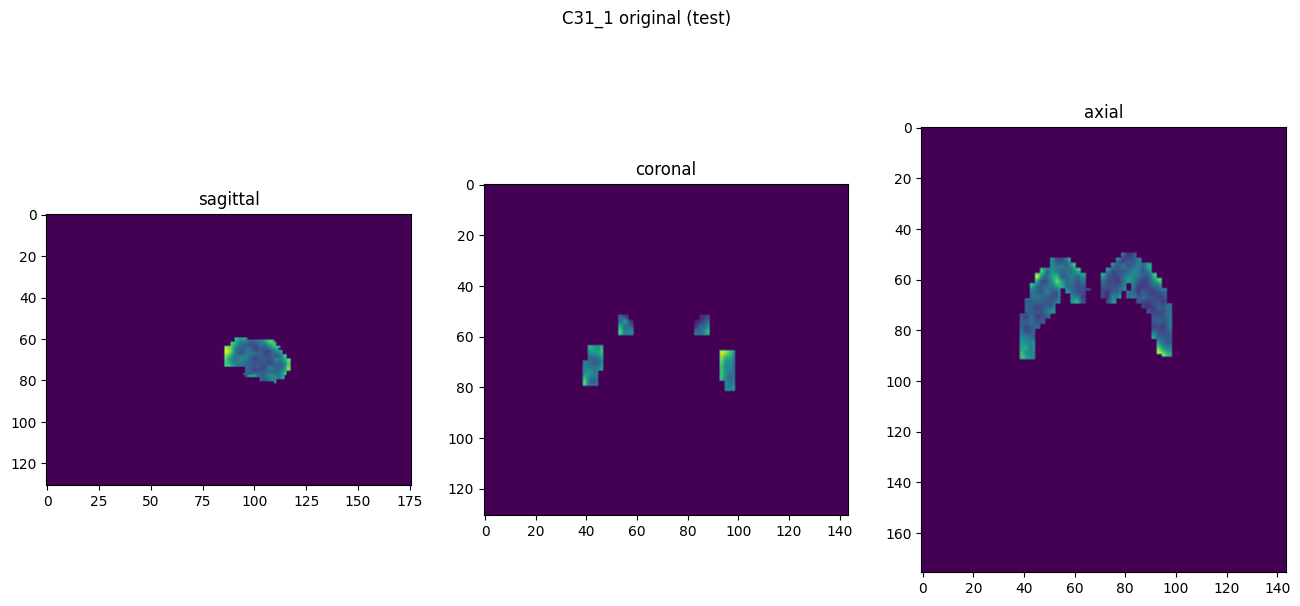

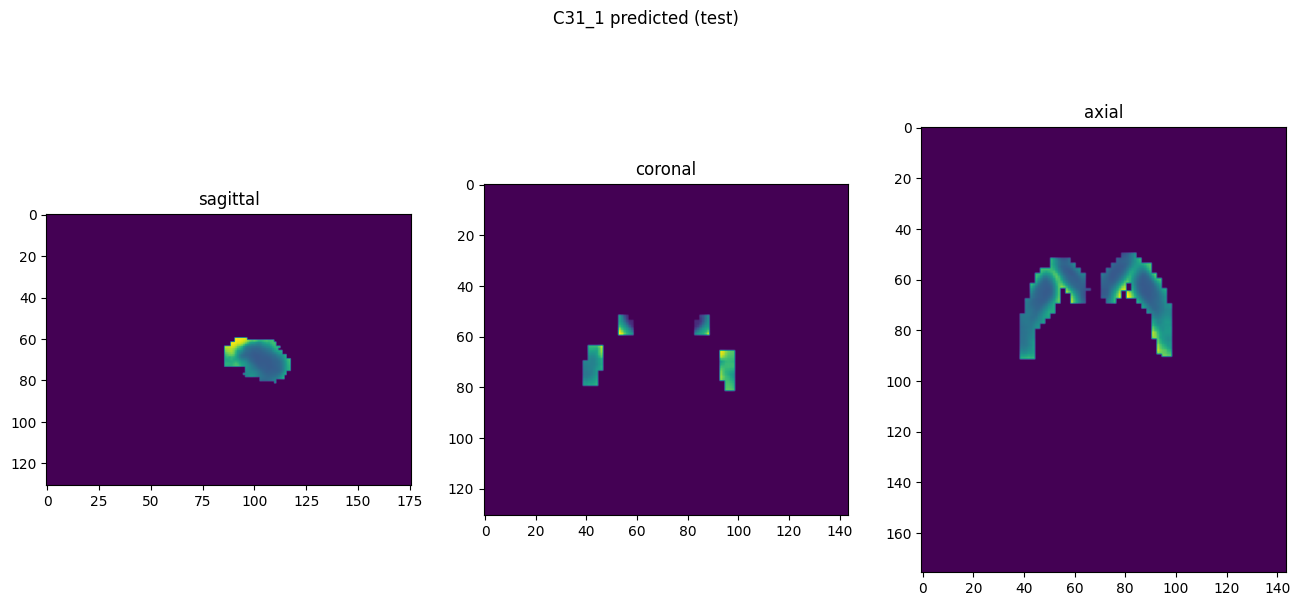

In [10]:
showResults(model, gen, threshold=None, background=False)